In [ ]:
!source activate /scratch/cm6627/diffeo_cnn/penv

In [1]:
import numpy as np
rng = np.random.default_rng(seed = 37)

import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import os

import torch as t
import torchvision as tv
from torchvision.transforms import v2
#from torchinfo import summary

from tqdm import tqdm

from PIL import Image

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import sys

device = t.device("cuda") if t.cuda.is_available() else t.device("cpu")
print(f'Using {device} for inference')

ModuleNotFoundError: No module named 'torch'

In [ ]:
ENV2 = tv.models.efficientnet_v2_s(weights = tv.models.EfficientNet_V2_S_Weights.DEFAULT).to(device)
ENV2.eval();
t.set_grad_enabled(False)
for param in ENV2.parameters():
    param.requires_grad = False
inference_transform = tv.models.EfficientNet_B0_Weights.IMAGENET1K_V1.transforms()

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 210MB/s]


In [ ]:
my_inference_transforms = v2.Compose([
    lambda x: x.convert('RGB'),
    inference_transform,
])
visualization_transforms = v2.Compose(
    [v2.ToImage(),
     v2.ToDtype(t.float32, scale=True),
     v2.CenterCrop(224),
     ])

In [ ]:
data_root = '/content/drive/Shareddrives/Diffeomorphisms_&_CNNs/'
imagenet_val = tv.datasets.ImageNet(data_root, split = 'val', transform = v2.CenterCrop(224))
imagenet_val_inference = tv.datasets.ImageNet(data_root, split = 'val', transform = my_inference_transforms)

In [ ]:
from distortion_utils import dense_transform_amplitude, sparse_transform_amplitude, create_grid_sample, find_inv_grid, jacobian_det, get_version

In [ ]:
def get_sparse_grid_sample(amplitudes, num_diffeo, x_cutoff = 10, y_cutoff = 10, num_terms = 3, x_resolution = 224, y_resolution = 224):
  batch_grid_sample = []
  # batch_inverse_grid_sample = []
  for amp in amplitudes:
    A_nm, B_nm = sparse_transform_amplitude(x_cutoff, y_cutoff, num_terms, amplitude = amp, loop = num_diffeo)

    #A_nm = np.mean(A_nm, axis = 0)
    #B_nm = np.mean(B_nm, axis = 0)
    for A, B in zip(A_nm, B_nm):
      grid_sample = create_grid_sample(x_resolution, y_resolution, A, B)
    #inverse_grid_sample, _ = find_inv_grid(grid_sample)
      batch_grid_sample.append(grid_sample)
    #batch_inverse_grid_sample.append(inverse_grid_sample)
  grid_sample = t.cat(batch_grid_sample)
  return grid_sample

In [ ]:
activation = {}
def getActivation(name):
    # the hook signature
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [ ]:
handles = []
def retrieve_layer_activation(model, input, layer_index):
  if len(input) == 3: input = input[None, :, :, :]

  layers = list(model.children())
  layers_flat = flatten(layers)

  for index in layer_index:
    handles.append(layers_flat[index - 1].register_forward_hook(getActivation(str(index))))

  with t.no_grad(): model(input)
  for handle in handles: handle.remove()

  return

def flatten(array):
    result = []
    for element in array:
        if hasattr(element, "__iter__"):
            result.extend(flatten(element))
        else:
            result.append(element)
    return result

In [ ]:
imagenet_val_loader = iter(t.utils.data.DataLoader(imagenet_val_inference, batch_size = 1, shuffle=False))

In [ ]:
amp_steps = 4
diffeo_num = 1
diffeo_amp = t.linspace(0, 1.5, amp_steps)
grid_sample = get_sparse_grid_sample(diffeo_amp, diffeo_num, x_cutoff= 10, y_cutoff = 10, num_terms = 3, x_resolution =224, y_resolution= 224)

# Recreate Data

In [ ]:
target_layer = str(43)

layer_activation = []
path = '/content/drive/Shareddrives/Diffeomorphisms_&_CNNs/Alex/data/'
t.save(grid_sample, path + '20-50-10-10-3-224-224_grid_sample.pt')
for i in tqdm(range(1000)): # For looping over images
  file_prefix = f'20-50-10-10-3-224-224_image-{i:04d}_activation'
  val_image, _ = next(imagenet_val_loader)
  distorted_list = t.nn.functional.grid_sample(val_image.repeat(amp_steps * diffeo_num,1,1,1), grid_sample, mode = 'bilinear').to(device)
  retrieve_layer_activation(ENV2, distorted_list, [5,9,13,19,28,36,43,46,49])
  layer_activation.append(activation[target_layer].to('cpu'))
  activation = {}
  handle = []

100%|██████████| 1000/1000 [15:04<00:00,  1.11it/s]


# Sort Features and Labels

In [ ]:
diffeo_amp

tensor([0.0000, 0.5000, 1.0000, 1.5000])

In [ ]:
activations_BeforeDiffeo = [layer_activation[i][0].view(-1) for i in range(len(layer_activation))]
activations_AfterDiffeo_0p5 = [layer_activation[i][1].view(-1) for i in range(len(layer_activation))]
activations_AfterDiffeo_1 = [layer_activation[i][2].view(-1) for i in range(len(layer_activation))]
activations_AfterDiffeo_1p5 = [layer_activation[i][3].view(-1) for i in range(len(layer_activation))]


features = activations_BeforeDiffeo
labels0 = activations_AfterDiffeo_0p5
labels1 = activations_AfterDiffeo_1
labels2 = activations_AfterDiffeo_1p5

## Visualize the Activations

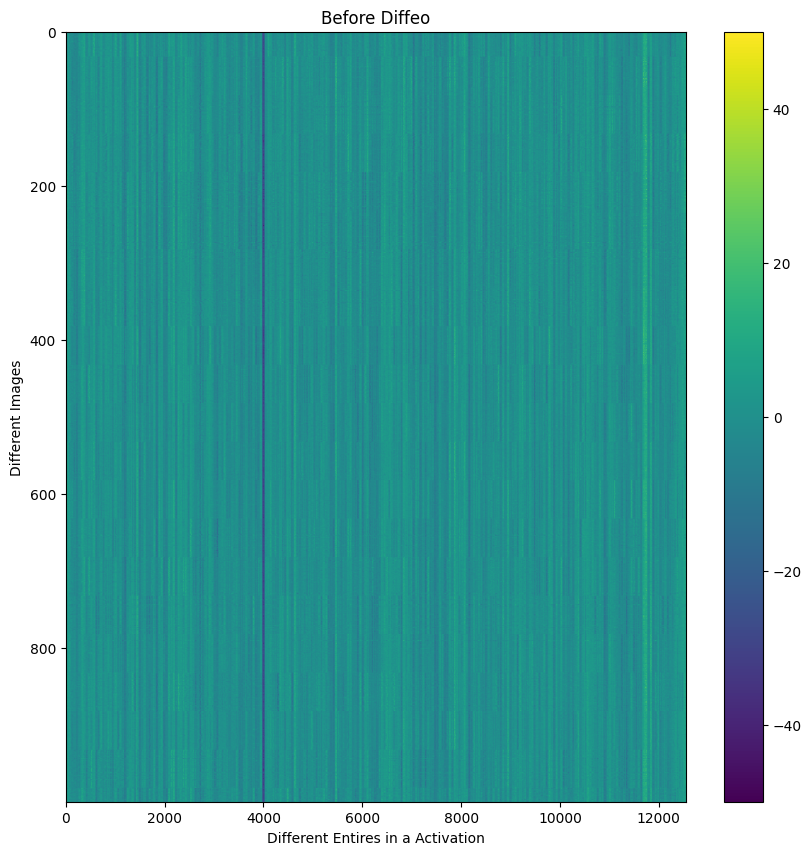

In [ ]:
def visualize(activations: list, title: str):
  plt.figure(figsize=(10, 10))

  data = np.vstack(activations)

  # Plot heatmap
  plt.imshow(data, cmap='viridis', aspect='auto', vmin=-50, vmax=50)
  plt.colorbar()
  plt.xlabel('Different Entires in a Activation')
  plt.ylabel('Different Images')
  plt.title(title)
  plt.show()

visualize(activations_BeforeDiffeo, 'Before Diffeo')

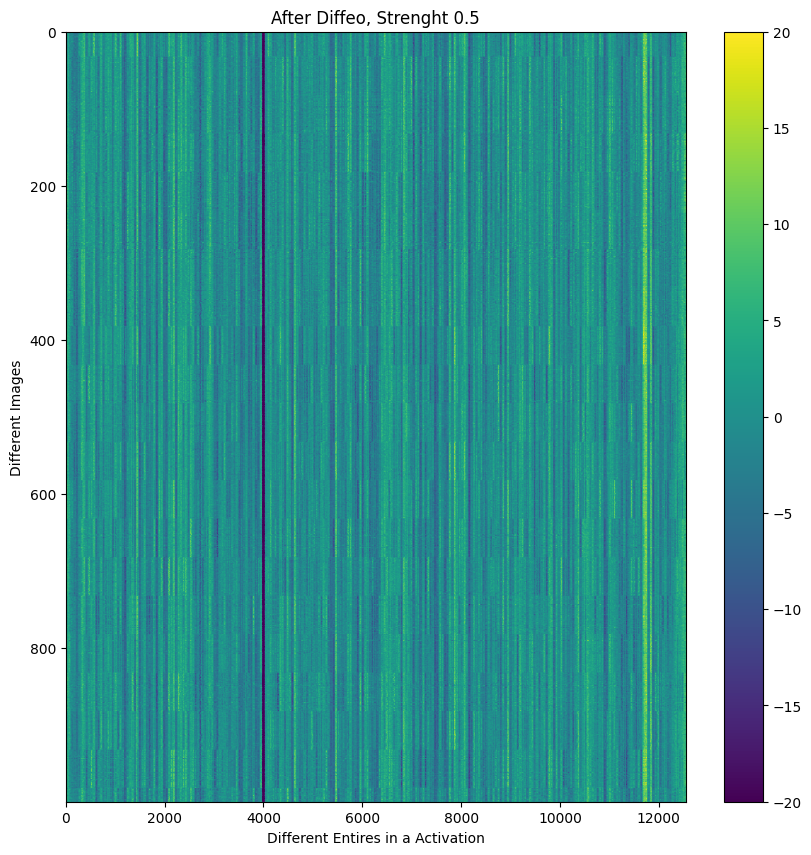

In [ ]:
visualize(activations_AfterDiffeo_0p5, 'After Diffeo, Strenght 0.5')

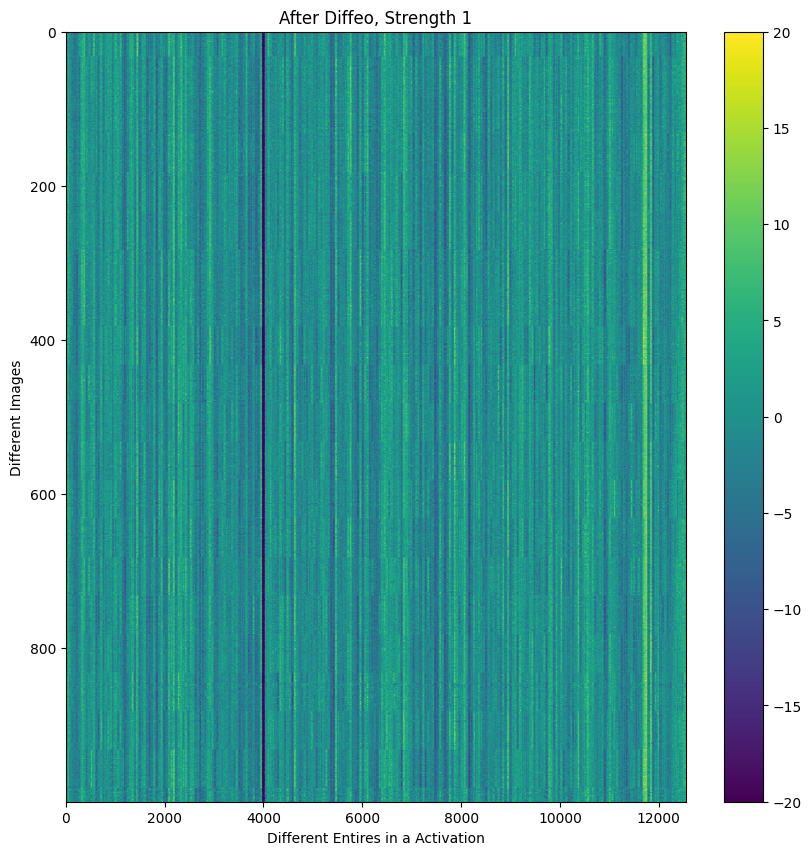

In [ ]:
visualize(activations_AfterDiffeo_1, 'After Diffeo, Strength 1')

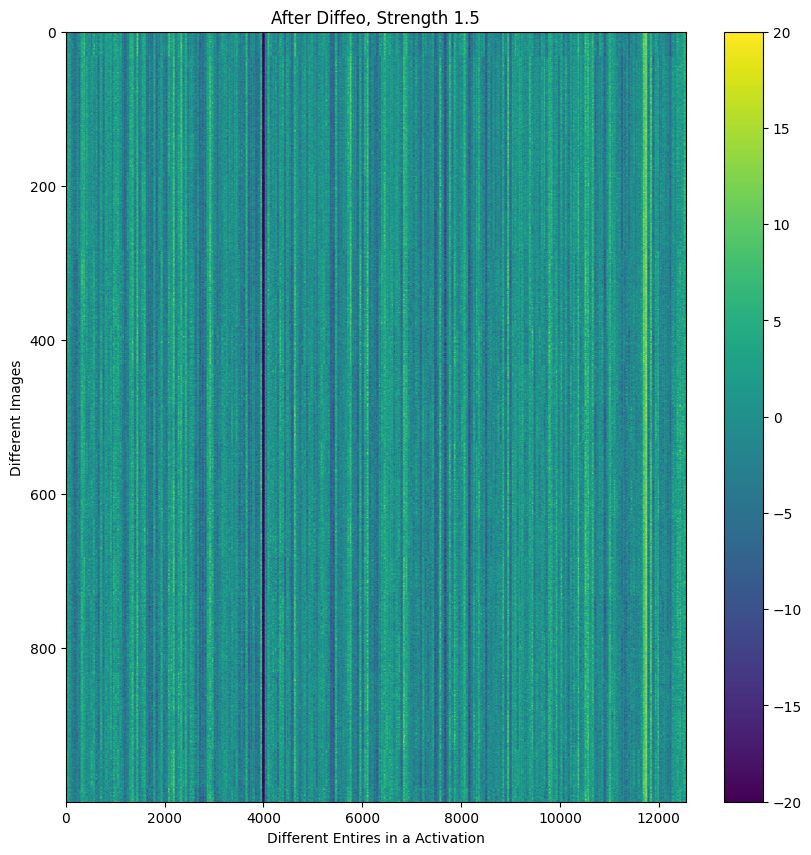

In [ ]:
visualize(activations_AfterDiffeo_1p5, 'After Diffeo, Strength 1.5')

# Prediction

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [ ]:
mse, r2

(11.015123, -0.05606837158521252)

In [ ]:
num_features

array([  0,  25,  50,  75, 100, 125, 150, 175, 200, 225, 250, 275, 300,
       325, 350, 375, 400, 425, 450, 475, 500, 525, 550, 575, 600, 625,
       650, 675, 700, 725, 750, 775])

In [ ]:
X_train[0]

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
num_features = np.arange(0, len(X_train), 25)
for num in num_features:
  X_train_trunc = X_train[0:num]

  # Create a linear regression model
  model = LinearRegression()

  # Train the model
  model.fit(X_train_trunc, y_train)

  # Make predictions
  y_pred = model.predict(X_test)

  # Evaluate the model
  mse = mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)
